# Generate circlized plot for gender only analysis DEG results

In [1]:
library(biomaRt)
library(circlize)
library(tidyverse)
library(ComplexHeatmap)

circlize version 0.4.10
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))


-- Attaching packages --------------------------------------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0

-- Conflicts ------------------------------------------------------------------------------------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
x dplyr::select() masks biomaRt::se

## Prepare data

### Get gene annotation

In [2]:
ensembl = useEnsembl(biomart="ensembl", dataset="hsapiens_gene_ensembl")
biomart = getBM(attributes=c('ensembl_gene_id', 'chromosome_name', 
                         'start_position', 'end_position'),
            mart=ensembl)
biomart %>% head(2)

,ensembl_gene_id,chromosome_name,start_position,end_position
,<chr>,<chr>,<int>,<int>
1,ENSG00000210049,MT,577,647
2,ENSG00000211459,MT,648,1601


### Get logFC for differential expression analysis

In [3]:
deg = data.table::fread("../../_m/genes/diffExpr_EAvsAA_full.txt") %>%
    select(gencodeID, ensemblID, Symbol, logFC, "adj.P.Val")
deg %>% head(2)

Warning message in data.table::fread("../../_m/genes/diffExpr_EAvsAA_full.txt"):
"Detected 16 column names but the data has 17 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file."


gencodeID,ensemblID,Symbol,logFC,adj.P.Val
<chr>,<chr>,<chr>,<dbl>,<dbl>
ENSG00000272977.1,ENSG00000272977,,1.745629,5.683360e-39
ENSG00000182698.11,ENSG00000182698,RESP18,2.717543,8.066854e-37


### Merge data and select regions

In [4]:
bed = deg %>% 
    inner_join(biomart, by=c("ensemblID"="ensembl_gene_id")) %>%
    select(chromosome_name, start_position, end_position, logFC, "adj.P.Val") %>%
    mutate(chromosome_name=paste0('chr', chromosome_name))

bed_ea = bed %>% filter(logFC > 0, adj.P.Val < 0.05)
bed_aa = bed %>% filter(logFC < 0, adj.P.Val < 0.05)
bed_nonsig = bed %>% filter(adj.P.Val > 0.05)

## Circos Plot

In [21]:
plot_circos <- function(bed_list, colors, tissue_name){
    lgd_points = Legend(at=c("AA Bias", "EA Bias"), type="points", 
                        legend_gp=gpar(col = c("red", "blue")), 
                        title_position="topleft", title="Ethnicity", 
                        background="#FFFFFF")
    circos.clear() # clear plot if there is any
    circos.par("start.degree" = 90) # rotate 90 degrees
    # initialize with ideogram
    # use hg38, default is hg19
    circos.initializeWithIdeogram(species="hg38") 
    # add logFC as a genomic track
    circos.genomicTrack(bed_list, track.height=inches_h(1),
                        text(0, 0, tissue_name, cex = 1),
                        panel.fun = function(region, value, ...) {
                            i = getI(...)
                            circos.genomicPoints(region, value, pch = 16, 
                                                 cex = 0.6, col = colors[i], ...)
    })
    draw(lgd_points, x=unit(5, "mm"), y=unit(5, "mm"), just=c("left", "bottom"))
}

In [6]:
tissue = 'DLPFC'
tissue_name = gsub(" ", "_", tissue)

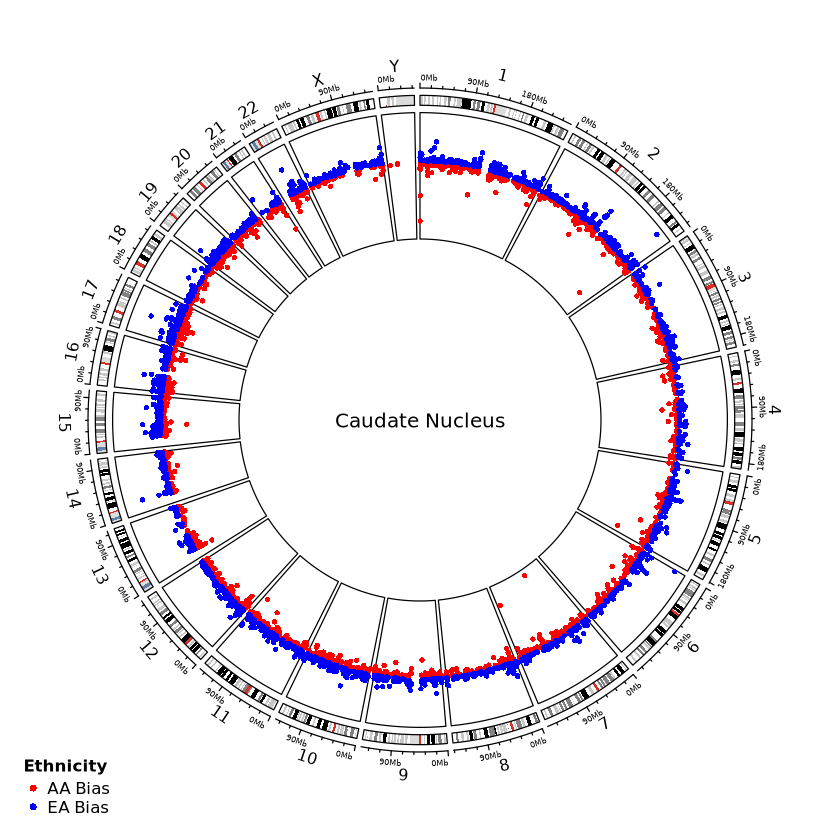

In [22]:
plot_circos(list(bed_aa, bed_ea), c("red", "blue"), tissue)

In [23]:
png(filename = paste0("significant_circos_plot_", tissue_name, ".png"))
plot_circos(list(bed_aa, bed_ea), c("red", "blue"), tissue)
dev.off()

pdf(file = paste0("significant_circos_plot_", tissue_name, ".pdf"))
plot_circos(list(bed_aa, bed_ea), c("red", "blue"), tissue)
dev.off()

svg(filename = paste0("significant_circos_plot_", tissue_name, ".svg"))
plot_circos(list(bed_aa, bed_ea), c("red", "blue"), tissue)
dev.off()

png 
  2

png 
  2

png 
  2

In [ ]:
plot_circos(list(bed_nonsig, bed_aa, bed_ea), 
            c("gray", "red", "blue"), tissue)

In [ ]:
png(filename = paste0("allGenes_circos_plot_", tissue_name, ".png"))
plot_circos(list(bed_nonsig, bed_aa, bed_ea), 
            c('gray', 'red', 'blue'), tissue)
dev.off()

pdf(file = paste0("allGenes_circos_plot_", tissue_name, ".pdf"))
plot_circos(list(bed_nonsig, bed_aa, bed_ea), 
            c('gray', 'red', 'blue'), tissue)
dev.off()

svg(filename = paste0("allGenes_circos_plot_", tissue_name, ".svg"))
plot_circos(list(bed_nonsig, bed_aa, bed_ea), 
            c('gray', 'red', 'blue'), tissue)
dev.off()